# Análisis estadístico del rendimiento de las situaciones tácticas ofensivas y su relación con los jugadores que participan en ellas
Trabajo fin de Diploma Universitario en Analítica Avanzada en Balonmano.

In [33]:
import turicreate
from turicreate import SArray
import matplotlib.pyplot as plt
import itertools
import numpy as np
TacticaSF = turicreate.SFrame.read_csv('PrimeraVuelta_ofuscado.csv')

%matplotlib inline

Finished parsing file /mnt/d/Balonmano/JUPYTER/PrimeraVuelta_ofuscado.csv

Parsing completed. Parsed 100 lines in 0.057524 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,int,int,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /mnt/d/Balonmano/JUPYTER/PrimeraVuelta_ofuscado.csv

Parsing completed. Parsed 745 lines in 0.059316 secs.

**745 acciones analizadas**

In [34]:
TacticaSF.show()

Materializing SFrame

Porcentaje de goles sobre el total: 

$ \frac{273}{(273+236+236)}*100=36.64 \% $

Con este cálculo se consideran las acciones de "Nada" tan negativas como las de "Pérdida".  
Recalculamos con  "Nada" = 1/3 de "Pérdida".  

$ \frac{273}{(273+\frac{236}{3}+236)}*100=46.45 \% $

In [35]:
#returns a list of the players in the SFrame
def get_players (actionsSF):    
    alineacion = ''
    for accion in actionsSF:        
        alineacion = alineacion + ';' + accion['Alineación']
    SAalineacion = SArray(data=[alineacion[1:]], dtype=str)
    alineacion_dict = turicreate.text_analytics.count_words(SAalineacion, delimiters=[';'])[0]
    jugadores = list(alineacion_dict.keys())
    return jugadores

In [36]:
#returns a list of every combinations of players of size 'size'
def get_combinations(players,size):
    return list(itertools.combinations(players,size))

In [37]:
#combinations = list of combinations of players
#actions = list of actions
#min_actions = minimum count of actions played for all players in each combination to consider the success average
#neg_coef_nada = Negative coefficient applied to the actions with Resultado = 'Nada'. Default = 0 (ignoring it)
#    returns a dict
#      key: list of players combination
#      value: [success average (ordering dict factor), count of considered actions to calculate the average]
def get_success_combinations(combinations, actions, min_actions = 0, neg_coef_nada=0):
    success = {}
    for players in combinations:
        suc, count = success_avg(players, actions, min_actions, neg_coef_nada)
        if (suc != -1):
            success[players] = [suc, count]
    return {key: value for key, value in sorted(success.items(), key=lambda item: item[1], reverse=True)}

In [38]:
#players = list of players
#actions = actions in which we want to calculate the success average of all 'players' playing together
#min_actions = minimum count of actions played for all 'players' to consider the average
#neg_coef_nada = Negative coefficient applied to the actions with Resultado = 'Nada'. Default = 0 (ignoring it)
#    returns success average (decimal) and the number of actions used to calculate de average(int)
def success_avg(players, actions, min_actions=0, neg_coef_nada=0):
    num_actions = 0
    num_gol = 0
    for action in actions:        
        if (are_playing_together(players, action)):
            if (action['Resultado']=='Nada'):
                num_actions += neg_coef_nada
            elif (action['Resultado']=='Pérdida'):
                num_actions += 1
            else:
                num_actions += 1
                num_gol += 1
    if (num_actions <= min_actions):
        # not enough actions played for all 'players' together
        return (-1,num_actions)
    return (round(num_gol/num_actions, 2),round(num_actions, 2))

In [39]:
#players = list of players
#action = action in which we want to check if all the players are playing
#    returns boolean
def are_playing_together(players, action):
    playing = True
    for player in players:
        if (player.lower() not in action['Alineación'].lower()):
            playing = False
            break
    return playing

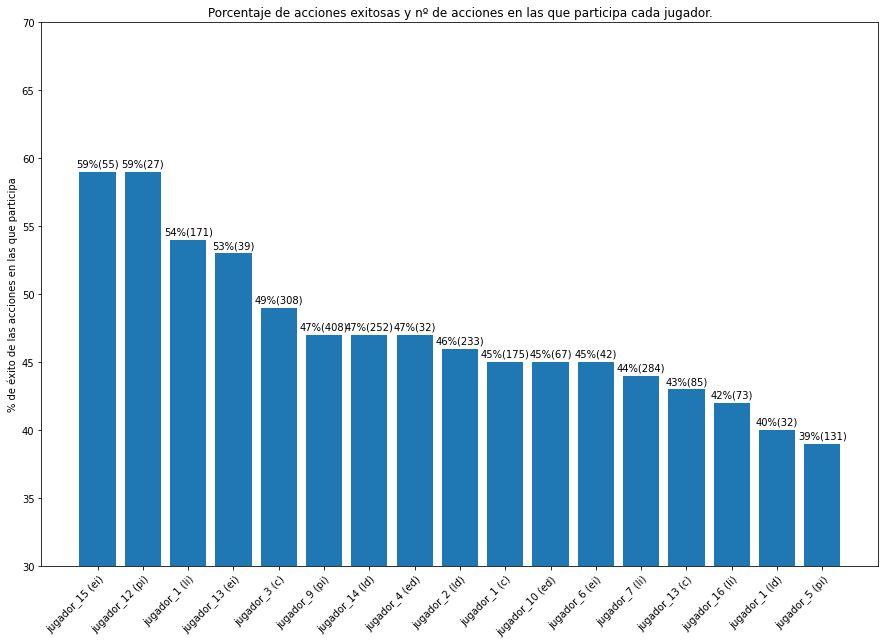

In [40]:
players = get_players(TacticaSF)
individual_success = get_success_combinations(get_combinations(players,1), TacticaSF, 25, 1/3)
individual_success_names = []
individual_success_count = []
individual_unsuccess_count = []
individual_success_prob = []
individual_count = []
for i in individual_success.keys():
    individual_success_names.append(i[0])
for i in individual_success.values():
    individual_count.append(i[1])
    individual_success_count.append(round(i[0]*i[1],2))
    individual_unsuccess_count.append(round((1-i[0])*i[1],2))
    individual_success_prob.append(int(i[0]*100))
    
fig, ax = plt.subplots(figsize=(15,10))
plt.ylim([30, 70])

rects1 = ax.bar(individual_success_names, individual_success_prob, label='% Éxito')
#ax.bar(individual_success_names, individual_unsuccess_count, label='Fracaso', bottom=individual_success_count)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

ax.set_ylabel('% de éxito de las acciones en las que participa')
ax.set_title('Porcentaje de acciones exitosas y nº de acciones en las que participa cada jugador.')
index = 0
for rect in rects1:
        height = rect.get_height()
        ax.annotate(str(individual_success_prob[index])+"%("+str(int(individual_count[index]))+")",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        index +=1

plt.show()

In [41]:
def alineacion (lista):
    alineacion_str = ''
    puestos = ['(li)','(c)','(ld)','(pi)']
    for puesto in puestos:
        for jugador in lista:
            if puesto in jugador:
                alineacion_str += jugador + '\n'
    return alineacion_str

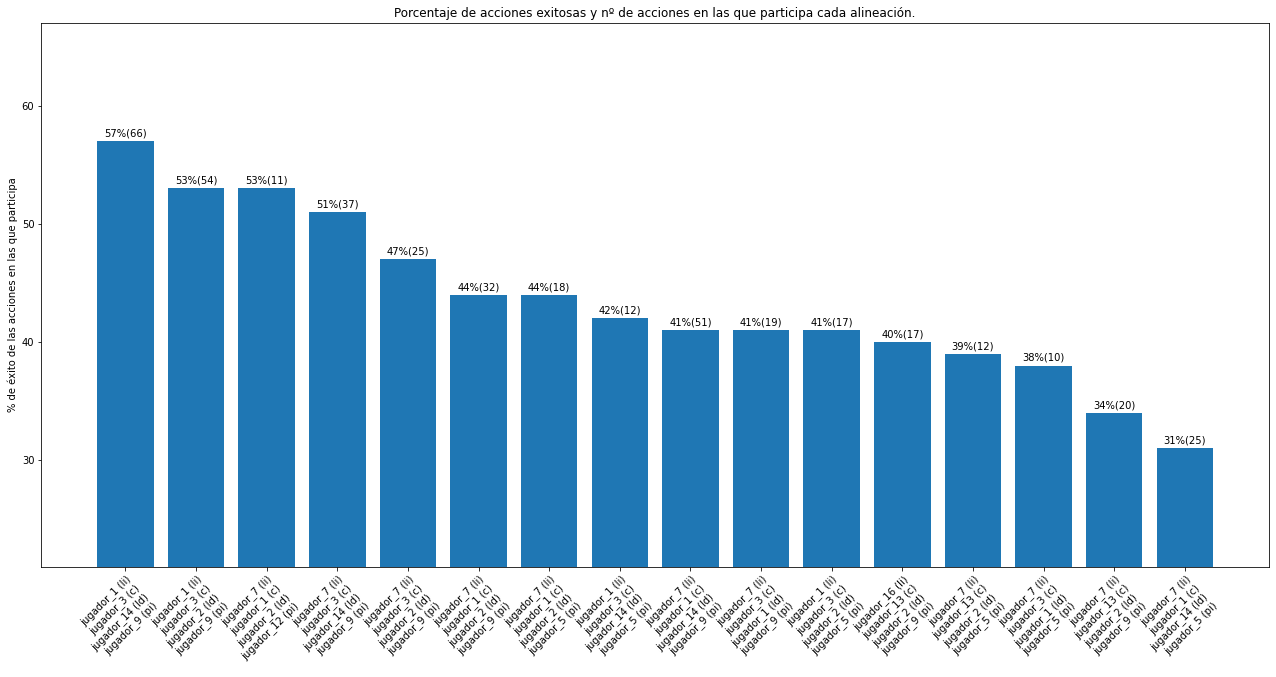

In [42]:
first_line_and_pivots = [i for i in players if ('(li)' in i
                                                or '(c)' in i
                                               or '(ld)' in i
                                               or '(pi)' in i)]
#Combinaciones de tamaño 4 de primeras líneas y pivotes
#Jugadas utilizadas almenos 10 veces por la correspondiente combinación de jugadores
#Coeficiente de negatividad de las acciones de "Nada" de 1/3
individual_success = get_success_combinations(get_combinations(first_line_and_pivots,4), TacticaSF, 10, 1/3)
individual_success_names = []
individual_success_count = []
individual_unsuccess_count = []
individual_success_prob = []
individual_count = []
for i in individual_success.keys():
    individual_success_names.append(alineacion(i))
for i in individual_success.values():
    individual_count.append(i[1])
    individual_success_count.append(round(i[0]*i[1],2))
    individual_unsuccess_count.append(round((1-i[0])*i[1],2))
    individual_success_prob.append(int(i[0]*100))
    
fig, ax = plt.subplots(figsize=(22,10))
plt.ylim([min(individual_success_prob)-10, max(individual_success_prob)+10])

rects1 = ax.bar(individual_success_names, individual_success_prob, label='% Éxito')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

ax.set_ylabel('% de éxito de las acciones en las que participa')
ax.set_title('Porcentaje de acciones exitosas y nº de acciones en las que participa cada alineación.')
index = 0
for rect in rects1:
        height = rect.get_height()
        ax.annotate(str(individual_success_prob[index])+"%("+str(int(individual_count[index]))+")",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        index +=1

plt.show()

In [43]:
def show_prob_plot(prob_matrix, players, title="Success probability",colors="Greens"):
    plt.set_cmap(colors)
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(prob_matrix)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(players)))
    ax.set_yticks(np.arange(len(players)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(players)
    ax.set_yticklabels(players)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(players)):
        for j in range(len(players)):
            text = ax.text(j, i, prob_matrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title(title)

In [44]:
def delete_empty (matrix,labels):
    index = 0
    empty_indexes = []
    for row in range(matrix.shape[0]):
        empty=True
        for cell in matrix[row,:]:
            if cell!=-1:
                empty=False
                break
        if empty:
            empty_indexes.append(index)
        index += 1
    sanitized_matrix = np.delete(matrix,empty_indexes,axis=0)
    sanitized_matrix = np.delete(sanitized_matrix,empty_indexes,axis=1)
    label_index = 0
    sanitized_labels = []
    for label in labels:
        if label_index not in empty_indexes:
            sanitized_labels.append(labels[label_index])
        label_index += 1
    return (sanitized_matrix, sanitized_labels)

In [45]:
def adj_matrix (actionsSF, player_list = [], action_list=[], neg_coef_nada=0):
    player_count = len(player_list)
    # If player_list is not received then we use the whole list
    if player_count == 0:
        player_list = list(get_players(actionsSF).keys())
        player_count = len(player_list)
    action_count = len(action_list)
    # If action_list is not received then we use the whole list
    if action_count == 0:
        action_list = list(get_actions(actionsSF).keys())
        action_count = len(action_list)
    success_matrix = np.zeros((player_count,player_count))
    unsuccess_matrix = np.zeros((player_count,player_count))
    for action in actionsSF:
        i = 0
        for player in player_list:
            if i+1<player_count:
                j = i+1
                for player2 in player_list[j:]:
                    if (action['Jugada'] in action_list
                        and player in action['Alineación'].lower()
                        and player2 in action['Alineación'].lower()):
                        if action['Resultado'] == 'Gol':
                            success_matrix[i][j] += 1
                            success_matrix[j][i] += 1
                        elif action['Resultado'] == 'Pérdida':
                            unsuccess_matrix[i][j] += 1
                            unsuccess_matrix[j][i] += 1
                        else:
                            unsuccess_matrix[i][j] += neg_coef_nada
                            unsuccess_matrix[j][i] += neg_coef_nada
                    j=j+1
                i=i+1
    return (player_list, success_matrix, unsuccess_matrix)

In [46]:
def get_actions (actionsSF, min_count=0):
    actions = {}
    for action in actionsSF['Jugada']:
        if action not in actions:
            actions[action] = 0
        actions[action] += 1
    return dict(filter(lambda elem: elem[1] >= min_count,actions.items()))

In [47]:
def get_prob_matrix(matrix1,matrix2,min_cases=1):
    (x, y) = matrix1.shape
    prob_matrix = np.zeros((x, y))
    for row in range(x):
        for column in range(y):
            if (matrix1[row][column] + matrix2[row][column] < min_cases):
                prob_matrix[row][column] = -1
            else:
                prob_matrix[row][column] = round((matrix1[row][column]) / (matrix1[row][column] + matrix2[row][column]),2)
    return prob_matrix

In [48]:
(players, success_matrix, unsuccess_matrix) = adj_matrix (TacticaSF, first_line_and_pivots,neg_coef_nada=1/3)
prob_matrix = get_prob_matrix(success_matrix,unsuccess_matrix,10)

In [49]:
(sanitized_matrix, sanitized_players) = delete_empty(prob_matrix, players)

<Figure size 432x288 with 0 Axes>

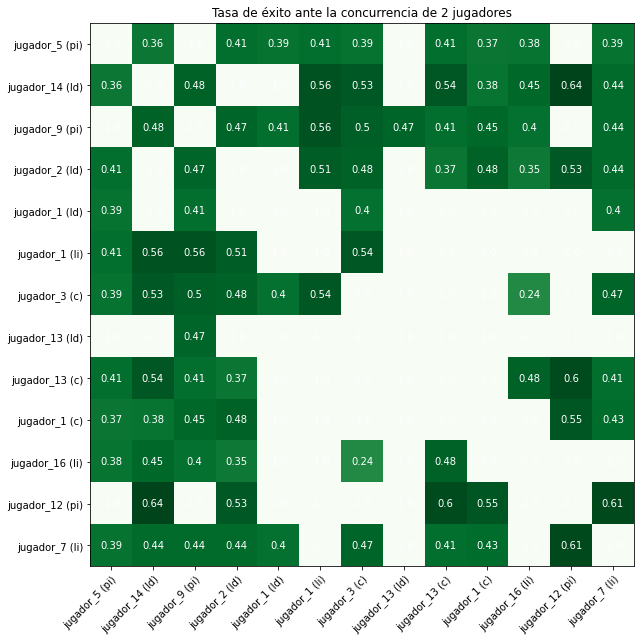

In [50]:
show_prob_plot(sanitized_matrix,sanitized_players,'Tasa de éxito ante la concurrencia de 2 jugadores')

In [51]:
def get_actions_prob(neg_coef_nada=0,min_count=1,TacticaSF=TacticaSF,Duration=True):
    success_dict = {}
    unsuccess_dict = {}
    actions_prob = {}
    duration_acc = {}
    duration_count = {}
    for action in TacticaSF:
        if Duration:
            if action['Jugada'] not in duration_acc:
                duration_acc[action['Jugada']] = action['Duración']
                duration_count[action['Jugada']] = 1
            else:
                duration_acc[action['Jugada']] += action['Duración']
                duration_count[action['Jugada']] += 1
        if action['Resultado']=='Gol':
            if action['Jugada'] not in success_dict:
                success_dict[action['Jugada']] = 1
            else:
                success_dict[action['Jugada']] += 1
        elif action['Resultado']=='Pérdida':
            if action['Jugada'] not in unsuccess_dict:
                unsuccess_dict[action['Jugada']] = 1
            else:
                unsuccess_dict[action['Jugada']] += 1
        else:
            if action['Jugada'] not in unsuccess_dict:
                unsuccess_dict[action['Jugada']] = neg_coef_nada
            else:
                unsuccess_dict[action['Jugada']] += neg_coef_nada
    for action in success_dict:
        unsuccess_value = 0
        if Duration:
            duration = duration_acc[action]/duration_count[action]
            if action in unsuccess_dict:
                unsuccess_value = unsuccess_dict[action]
            actions_prob[action]=[round(success_dict[action]/(success_dict[action]+unsuccess_value),2),
                                  round(success_dict[action]+unsuccess_value,2),round(duration/1000,2)]
        else:
            if action in unsuccess_dict:
                unsuccess_value = unsuccess_dict[action]
            actions_prob[action]=[round(success_dict[action]/(success_dict[action]+unsuccess_value),2),
                                  round(success_dict[action]+unsuccess_value,2)]
        filtered_actions_prob = {}
        for (key, value) in actions_prob.items():
            if value[1]>=min_count:
                filtered_actions_prob[key] = value
    return sorted(filtered_actions_prob.items(), key=lambda x: x[1][0], reverse=True)
probs = get_actions_prob(1/3,10)

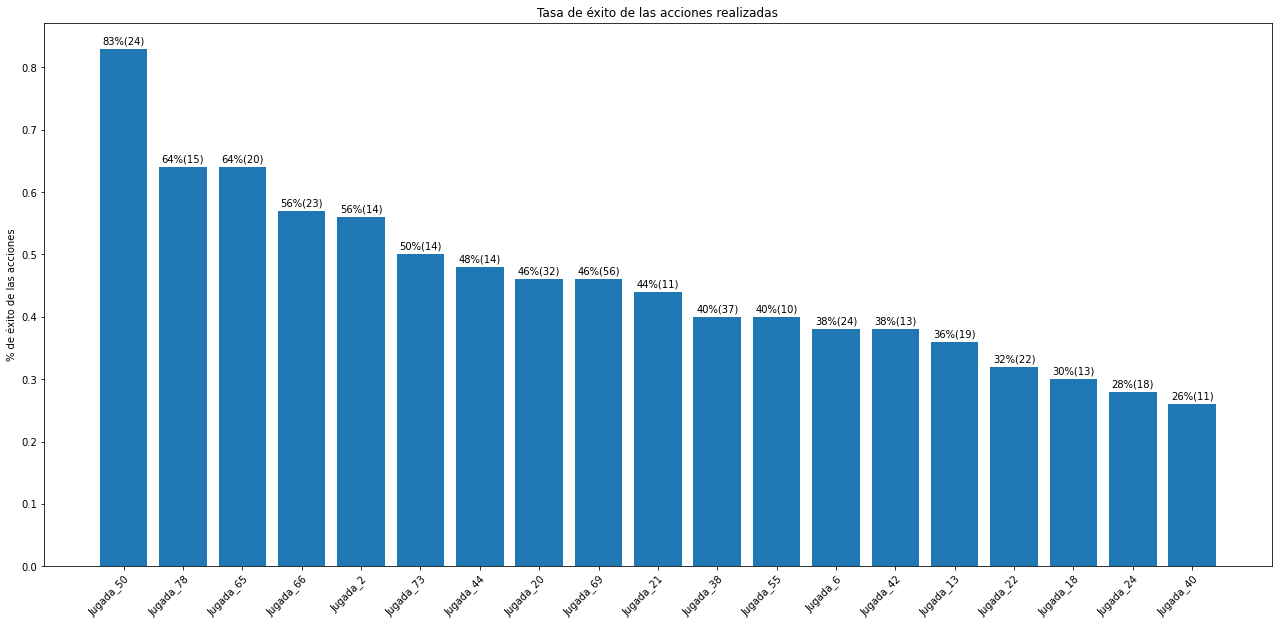

In [52]:
fig, ax = plt.subplots(figsize=(22,10))
nombres = []
porcentajes = []
count = []
for prob in probs:
    nombres.append(prob[0])
    porcentajes.append(prob[1][0])
    count.append(prob[1][1])

rects1 = ax.bar(nombres, porcentajes, label='% Éxito')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

ax.set_ylabel('% de éxito de las acciones')
ax.set_title('Tasa de éxito de las acciones realizadas')
index = 0
for rect in rects1:
        height = rect.get_height()
        ax.annotate(str(int(porcentajes[index]*100))+"%("+str(int(count[index]))+")",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        index +=1

plt.show()

In [53]:
def adj_matrix_actions (actionsSF, player_list = [], action_list=[], neg_coef_nada=0):
    player_count = len(player_list)
    # If player_list is not received then we use the whole list
    if player_count == 0:
        player_list = list(get_players(actionsSF).keys())
        player_count = len(player_list)
    action_count = len(action_list)
    # If action_list is not received then we use the whole list
    if action_count == 0:
        action_list = list(get_actions(actionsSF).keys())
        action_count = len(action_list)
    success_matrix = np.zeros((player_count,action_count))
    unsuccess_matrix = np.zeros((player_count,action_count))
    for action in actionsSF:
        p = 0;
        for player in player_list:
            a = 0;
            for action_name in action_list:
                if (player in action['Alineación'].lower()
                    and action_name == action['Jugada']):
                        if action['Resultado'] == 'Gol':
                            success_matrix[p][a] += 1
                        elif action['Resultado'] == 'Pérdida':
                            unsuccess_matrix[p][a] += 1
                        elif action['Resultado'] == 'Nada':
                            unsuccess_matrix[p][a] += neg_coef_nada
                a = a+1
            p = p+1
    return (player_list, action_list, success_matrix, unsuccess_matrix)

In [54]:
def show_prob_plot_actions(prob_matrix, players, actions, colors='Blues', header='Success'):
    plt.set_cmap(colors)
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(prob_matrix)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(actions)))
    ax.set_yticks(np.arange(len(players)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(actions)
    ax.set_yticklabels(players)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(players)):
        for j in range(len(actions)):
            text = ax.text(j, i, prob_matrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title(header)

In [55]:
def get_players (actionsSF, min_count=0):    
    alineacion = ''
    for accion in actionsSF:        
        alineacion = alineacion + ';' + accion['Alineación']
    SAalineacion = SArray(data=[alineacion[1:]], dtype=str)
    alineacion_dict = turicreate.text_analytics.count_words(SAalineacion, delimiters=[';'])[0]
    #jugadores = list(alineacion_dict.keys()) 
    return dict(filter(lambda elem: elem[1] >= min_count,alineacion_dict.items()))

<Figure size 432x288 with 0 Axes>

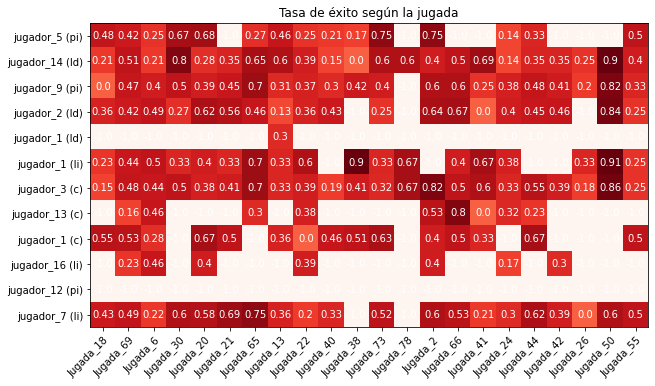

In [56]:
#NOT SHOWING INFO WHERE THE PLAYER DON'T HAVE AT LEAST 3 ACTIONS
#Actions we have done at least 10 times
less_actions = list(get_actions(TacticaSF,10).keys())
less_players = list(get_players(TacticaSF,20).keys())
#Only first line players
only_first_line = [player for player in less_players if ('(li)' in player or '(c)' in player or '(ld)' in player or '(pi)' in player) ]
(players, actions, success_matrix, unsuccess_matrix) = adj_matrix_actions(TacticaSF, action_list=less_actions,
                                                                                         player_list=only_first_line,
                                                                         neg_coef_nada=1/3)
prob_matrix = get_prob_matrix(success_matrix,unsuccess_matrix, min_cases=3)
show_prob_plot_actions(prob_matrix, players, actions, 'Reds', header='Tasa de éxito según la jugada')

In [61]:
def getAlineacionesSF():
    TacticaDF = TacticaSF.to_dataframe()
    split = TacticaDF['Alineación'].str.split(";",expand=True)
    puestos = {'(li)':'Lateral Izquierdo',
          '(c)':'Central',
          '(ld)':'Lateral Derecho',
          '(ed)':'Extremo Derecho',
          '(pi)':'Pivote',
          '(ei)':'Extremo Izquierdo'}
    index = 0
    for key,value in puestos.items():
        split[value] = split[index]
        index += 1
    for j in range(745):
        for key, value in puestos.items():
            split[value][j]=None
    for j in range(745):
        for i in range(6):
            for key, value in puestos.items():
                if split[i][j]!=None:
                    if key in split[i][j]:
                        split[value][j] = split[i][j]
    alineaciones = split[puestos.values()]
    alineacionesSF = turicreate.SFrame(alineaciones)
    alineacionesSF['Resultado'] = TacticaSF['Resultado']
    alineacionesSF['Jugada'] = TacticaSF['Jugada']
    for key, value in puestos.items():
        alineacionesSF = alineacionesSF.fillna(value,'')
    return alineacionesSF

In [63]:
def show_informe(jugador,puesto,jugada):
    alineacionesSF = getAlineacionesSF()
    acciones = alineacionesSF[alineacionesSF.apply(lambda x: True if (jugador in x[puesto]
                                                          and jugada == x['Jugada']) else False)]
    acciones.show()

In [64]:
show_informe("Jugador_1","Central","Jugada_6")

Materializing SFrame

In [65]:
def get_puesto(jugador):
    puestos = {'(li)':'Lateral Izquierdo',
          '(c)':'Central',
          '(ld)':'Lateral Derecho',
          '(ed)':'Extremo Derecho',
          '(pi)':'Pivote',
          '(ei)':'Extremo Izquierdo'}
    puesto = ''
    for key, value in puestos.items():
        if key in jugador:
            puesto = value
            break
    return puesto

In [66]:
def show_jugador(jugador):
    puesto = get_puesto(jugador)
    alineacionesSF = getAlineacionesSF()
    acciones = alineacionesSF[alineacionesSF[puesto]==jugador]
    #acciones = acciones[acciones['Jugada'].apply(lambda x: False if '6 vs 5' in x else True)] #quitamos las superioridades
    jugadas = acciones.groupby(key_column_names='Jugada', operations={'count': turicreate.aggregate.COUNT()})
    jugadas = jugadas.sort('count', ascending=False)
    top_jugadas = jugadas['Jugada'][:10]
    turicreate.show(jugadas['count'][:10],jugadas['Jugada'][:10],
                xlabel='Veces jugada',
                ylabel='Jugada',
                title='Jugadas más utilizadas por ' + jugador)
    top_acciones = acciones[acciones['Jugada'].apply(lambda x: True if x in top_jugadas else False)]    
    turicreate.show(top_acciones['Resultado'],top_acciones['Jugada'],
                xlabel='Resultado',
                ylabel='Jugada',
                title='Resultado de las jugadas más utilizadas por ' + jugador)

In [67]:
centrales = ['Jugador_3 (c)',
 'Jugador_13 (c)',
 'Jugador_1 (c)']
for jugador in centrales:
    show_jugador(jugador)

Materializing X axis SArray

Materializing Y axis SArray

Materializing X axis SArray

Materializing Y axis SArray

Materializing X axis SArray

Materializing Y axis SArray

Materializing X axis SArray

Materializing Y axis SArray

Materializing X axis SArray

Materializing Y axis SArray

Materializing X axis SArray

Materializing Y axis SArray